<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:center;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Woman Life Freedom</b></div>

<div style="text-align:center;">
  <img src="https://www.cfg.polis.cam.ac.uk/sites/www.cfg.polis.cam.ac.uk/files/styles/leading/public/shutterstock_2214441509.png?itok=8kwjDfB1" alt="woman_life_freedom">
</div>

<div style="text-align: justify;">
This notebook is dedicated to the brave women of Iran who are fighting for their freedom. Despite facing significant obstacles, Iranian women have continued to stand up for their rights and demand greater freedom and equality. We recognize that the struggle for women's rights is ongoing and that there is much work to be done. By supporting the fight for women's life and freedom, we are hoping to create a better future for all, one in which every person has the opportunity to live a free and fulfilling life.</div>

<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>WiDS 2023</b></div>

<a id="1.2"></a>
<h2 style="font-family: Verdana; font-size: 20px; font-style: normal; font-weight: normal; text-decoration: none; text-transform: none; letter-spacing: 2px; color: #155D07; background-color: #ffffff;"><b>WiDS 2023</b> Bayesian Optimization for CatBoost Hyperparameter Tuning and ...</h2>

<div style="text-align: justify;">In this Kaggle notebook, we have employed a variety of advanced machine learning techniques to improve our model's performance. Firstly, we have used <b>Bayesian optimization</b> to tune the hyperparameters of our <b>CatBoost model</b>, which is a powerful gradient boosting algorithm. This approach enables us to automatically search the hyperparameter space, saving us significant amounts of time and manual effort. 
Furthermore, we have utilized <b>Adversarial Validation</b>, a technique that involves training a model to differentiate between training and test data. This approach allows us to identify whether our model is overfitting or underfitting the training data, thus improving its overall robustness.
Additionally, we have implemented <b>Explainable Machine Learning using SHAP</b>, a method that provides insights into how different features affect our model's predictions. This enables us to understand and interpret our model's behavior more effectively, improving our ability to make informed decisions based on its outputs.
We have also employed <b>Pseudo Labeling</b>, a technique that involves using a model's predictions on unlabeled data to generate new labeled data. This approach can significantly increase the amount of training data available to us, improving our model's performance on the test data.
Lastly, we have used <b>Ensemble Learning</b>, which involves combining the outputs of multiple models to create a final prediction. This approach can improve the overall accuracy and robustness of our model, particularly in cases where individual models may struggle to capture the full complexity of the data.</div>

<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Table of content</b></div>

<div style="background-color:aliceblue; padding:30px; font-size:15px;color:#034914">
    
<a id="TOC"></a>
## Table of Content
* [Importing Required Libraries](#lib)
* [Reading Dataset](#read_data)
* [Processing Dataset](#process)
* [Plitting the Dataset](#split)
* [Adversarial Validation](#adv)
* [Bayesian Optimization for CatBoost](#bocat)
* [Feature Importance](#fi)
* [Explainability](#xml)
* [Pseudo Labeling](#PL)
* [Ensemble Learning](#EL)
* [Submission](#submit)
* [List of Kaggle Notebooks Used as a Reference](#list)

<a id="lib"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Importing Required Libraries</b></div> 

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from catboost import CatBoostRegressor

<a id="read_data"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Reading Dataset</b></div> 

In [1]:
train_raw = pd.read_csv('../../data/train_data.csv', parse_dates=["startdate"])
test_raw = pd.read_csv('../../data/test_data.csv', parse_dates=["startdate"])
submit = pd.read_csv('../../data/sample_solution.csv')
target = 'contest-tmp2m-14d__tmp2m'

train_raw.head()

NameError: name 'pd' is not defined

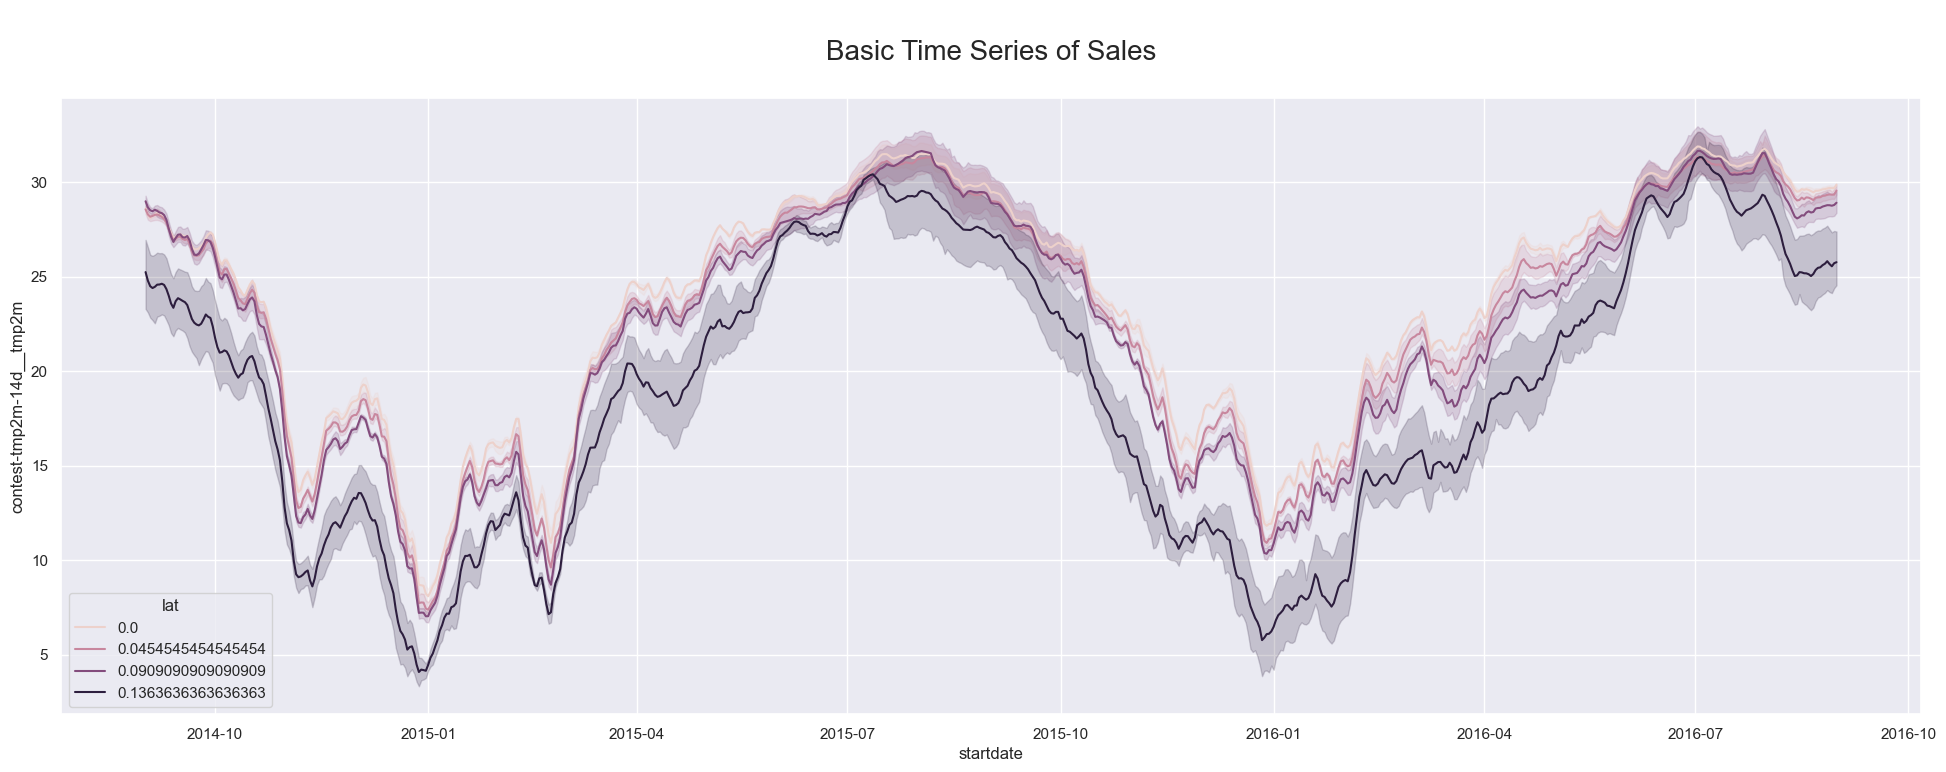

In [66]:
import seaborn as sns
sns.set(rc={'figure.figsize':(24,8)})
ax=sns.lineplot(data=train_raw[0:10000],x='startdate',y=target,hue='lat')
ax.axes.set_title("\nBasic Time Series of Sales\n",fontsize=20);

<a id = "process"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Preprocessing Dataset</b></div> 

In [35]:
def rmse(actual, predicted):
    return mean_squared_error(actual, predicted, squared=False)

def location_nom(train, test):
    # Ref: https://www.kaggle.com/code/flaviafelicioni/wids-2023-different-locations-train-test-solved
    scale = 14

    train.loc[:,'lat']=round(train.lat,scale)
    train.loc[:,'lon']=round(train.lon,scale)
    test.loc[:,'lat']=round(test.lat,scale)
    test.loc[:,'lon']=round(test.lon,scale)

    all_df = pd.concat([train, test], axis=0)
    all_df['loc_group'] = all_df.groupby(['lat','lon']).ngroup()
    train = all_df.iloc[:len(train)]
    test = all_df.iloc[len(train):].drop(target, axis=1)
    
    return train, test


def categorical_encode(train, test, feature_name):
    # le = LabelEncoder()
    # train['climateregions__climateregion'] = ohe.fit_transform(train['climateregions__climateregion'])
    # test['climateregions__climateregion'] = ohe.transform(test['climateregions__climateregion'])
    # return train, test
    # using OneHotEncoder
    ohe = OneHotEncoder()
    train_encoded = ohe.fit_transform(train[[feature_name]])
    test_encoded = ohe.transform(test[[feature_name]])
    
    train = train.drop([feature_name], axis=1)
    test = test.drop([feature_name], axis=1)
    
    train_encoded = pd.DataFrame(train_encoded.toarray(), columns=ohe.get_feature_names_out([feature_name]))
    test_encoded = pd.DataFrame(test_encoded.toarray(), columns=ohe.get_feature_names_out([feature_name]))
    
    train = pd.concat([train, train_encoded], axis=1)
    test = pd.concat([test, test_encoded], axis=1)
    
    return train, test

    
def fill_na(df):
    # TODO: fill na with mean or median
    df = df.sort_values(by=['loc_group', 'startdate']).ffill()
    return df

def add_season(df):
    month_to_season = {
        1: 0,
        2: 0,
        3: 1,
        4: 1,
        5: 1,
        6: 2,
        7: 2,
        8: 2,
        9: 3,
        10: 3,
        11: 3,
        12: 0,
    }
    df["season"] = df["month"].apply(lambda x: month_to_season[x])

from sklearn.preprocessing import FunctionTransformer
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

def encode_cyclical(df):
    # encode the day with a period of 365
    df["day_of_year_sin"] = sin_transformer(365).fit_transform(df["day_of_year"])
    df["day_of_year_cos"] = cos_transformer(365).fit_transform(df["day_of_year"])

    # encode the month with a period of 12
    df["month_sin"] = sin_transformer(12).fit_transform(df["month"])
    df["month_cos"] = cos_transformer(12).fit_transform(df["month"])

def creat_new_featute(df):
    df['year'] = df['startdate'].dt.year
    df['month'] = df['startdate'].dt.month
    df['day_of_year'] = df['startdate'].dt.dayofyear
    add_season(df)
    encode_cyclical(df)
    return df

#TODO: drop features with high correlation
def feature_engineering(train_raw, test_raw):
    train, test = location_nom(train_raw, test_raw)
    train = fill_na(train)
    train = creat_new_featute(train)
    test = creat_new_featute(test)
    train, test = categorical_encode(train, test, 'climateregions__climateregion')
    train, test = categorical_encode(train, test, 'season')

    # Xingjian: not drap lat and lon
    drop_cols = ['index', 'startdate', target]
    # drop_cols = ['index', 'startdate', 'lat', 'lon', target]
    features = [col for col in train.columns if col not in drop_cols]
    X = train[features]
    X_test = test[features]
    y = train[target]

    return X, y, X_test

# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Train and Validation</b></div> 

In [36]:
X, y, X_test = feature_engineering(train_raw.copy(), test_raw.copy())
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)
print(f'Train_shape: {X_train.shape}    |   Val_shape: {X_val.shape}    |   Test_shape: {X_test.shape}')

Train_shape: (300587, 269)    |   Val_shape: (75147, 269)    |   Test_shape: (31354, 269)


<a id = "adv"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Adversarial Validation</b></div>

Adversarial Validation is a technique used to ensure that the distribution of data in the training set is similar to that of the test set. This is important because if the data in the training set is not representative of the test set, the model's predictions may not be accurate.

To perform Adversarial Validation, the following steps are taken:

1. Combine the train and test features into a single set
1. Create a target label to indicate whether a sample is from the train or test set
1. Build a model to classify samples as belonging to the train or test set

If the model is able to accurately distinguish between train and test samples, this indicates that there are features in the data that are different between the two sets. Adversarial Validation can be used to identify these features by using the feature importance generated by the model and evaluating the separation between the train and test datasets using the AUC metric.

Reference: Pan, J., Pham, V., Dorairaj, M., Chen, H., & Lee, J. Y. (2020). Adversarial validation approach to concept drift problem in user targeting automation systems at uber. [arXiv preprint arXiv:2004.03045](https://arxiv.org/abs/2004.03045).

In [37]:
import lightgbm as lgb

def run_adversial_validation(train_X_ml, test_X_ml):
    
    lgb_params = {'n_estimators':100,
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'verbose': 0
                    }
    # combine train & test features, create label to identify test vs train
    ad_y = np.array([1]*train_X_ml.shape[0] + [0]*test_X_ml.shape[0])
    ad_X = pd.concat([train_X_ml, test_X_ml])

    # evaluate model performance using cross-validation
    lgb_data = lgb.Dataset(ad_X, ad_y)
    cv_lgb = lgb.cv(lgb_params, lgb_data)

    print("Adversarial Validation AUC Score: {}".format(cv_lgb['auc-mean'][-1]))
    
    # train model & get feature importance
    ad_val_mod = lgb.train(lgb_params, lgb_data)
    
    print(pd.DataFrame(
        {'feat':ad_X.columns, 
         'imp':ad_val_mod.feature_importance()}).sort_values('imp', ascending = False))
    
    return ad_val_mod

In [14]:
ad_val_mod = run_adversial_validation(X_train, X_test)

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.130843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.201045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

It seems that there is a concept drift between train and test dataset and removing features like "contest-pevpr-sfc-gauss-14d__pevpr" and "nmme0-tmp2m-34w__cancm30" might help to increase the performance. 

In [ ]:
# X.drop(['contest-pevpr-sfc-gauss-14d__pevpr','nmme0-tmp2m-34w__cancm30'], inplace = True)
# X_test.drop(['contest-pevpr-sfc-gauss-14d__pevpr','nmme0-tmp2m-34w__cancm30'], inplace = True)

<a id="bocat"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Bayesian Optimization for CatBoost</b></div> 

[Here's](https://en.wikipedia.org/wiki/Bayesian_optimization) a wikipedia article about Bayesian Optimization, it's essentially a way to find good parameters by searching for these parameters sequentially. So the next parameter search values depend on the performance of the previous parameter values. This is a popular technique for finding optimal parameters. This may take some time to run. Also, you can tune many parameters, below are just some of the parameters that I choose to tune. For this notebook, I'm going to fix the number of estimators to be 100 to save time when running this notebook, but you can increase it to your liking or tune that parameter too if you'd like. You can change the number of iterations and initial points.

In [41]:
# source: https://medium.com/ai-in-plain-english/catboost-cross-validated-bayesian-hyperparameter-tuning-91f1804b71dd

X1, Y1 = X.copy(), y.copy()

from catboost import Pool, cv, CatBoostRegressor
from bayes_opt import BayesianOptimization
from bayes_opt import BayesianOptimization as BO
import warnings
from sklearn.model_selection import * 
from sklearn.metrics import *

Use_BO = True

if Use_BO:
    #n_estimators,
    # num_leaves
    def CB_opt(depth, learning_rate, subsample, l2_leaf_reg, model_size_reg, random_strength, bagging_temperature): 

        scores = []
    #     skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1944)
        trainx, valx, trainy, valy = train_test_split(X1, Y1, test_size=0.33, random_state=42)

        reg = CatBoostRegressor(   
                                        verbose = 0,
                                        iterations=100,
                                        #n_estimators = 10,
                                        learning_rate = learning_rate,
                                        subsample = subsample, 
                                        l2_leaf_reg = l2_leaf_reg,
                                        max_depth = int(depth),
                                        #num_leaves = int(num_leaves),
                                        random_state = 1212,
                                        #grow_policy = "Lossguide",
    #                                     max_bin = int(max_bin),  
                                        use_best_model = True, 
                                        # bootstrap_type='Bayesian',
                                        loss_function='RMSE',
                                        model_size_reg = model_size_reg,
                                        random_strength = random_strength,
                                        bagging_temperature = bagging_temperature,
                                    )

        reg.fit(trainx, trainy, eval_set = (valx, valy))
        y_pred = reg.predict(valx)
        scores.append(rmse(valy, y_pred))

        return 1/np.mean(scores)

    #"n_estimators": (150,1200),
    # "num_leaves": (100,150),
    # "max_bin":(150,300),
    pbounds = {
               "depth": (6, 8),
            #    "learning_rate": (0.09, 0.1080689972639084),
               "learning_rate": (0.05, 0.0580689972639084),
               "subsample":(0.6, 0.900000011920929),
               "l2_leaf_reg":(2,4),
               "model_size_reg": (0.48, 0.5),
               "random_strength": (0.9, 1.0),
               "bagging_temperature": (0.6, 1.5),
    }

    optimizer = BayesianOptimization(f = CB_opt, pbounds = pbounds,  verbose = 2, random_state = 1212)

    optimizer.maximize(init_points = 10, n_iter = 50, acq = 'ucb', alpha = 1e-6)

    print(optimizer.max)

    max_bo_params = optimizer.max['params']

    max_bo_params

|   iter    |  target   | baggin... |   depth   | l2_lea... | learni... | model_... | random... | subsample |
-------------------------------------------------------------------------------------------------------------



Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument



| 1         | 0.739     | 0.8208    | 7.609     | 2.349     | 0.05782   | 0.4845    | 0.9869    | 0.6844    |
| 2         | 0.733     | 1.253     | 7.505     | 2.493     | 0.05623   | 0.4817    | 0.9891    | 0.6654    |
| 3         | 0.667     | 1.441     | 6.181     | 3.615     | 0.05314   | 0.4989    | 0.9017    | 0.7625    |
| 4         | 0.7305    | 0.8625    | 7.718     | 3.009     | 0.0558    | 0.4862    | 0.9266    | 0.6552    |
| 5         | 0.7172    | 0.8875    | 7.452     | 3.815     | 0.05379   | 0.4822    | 0.9265    | 0.8045    |
| 6         | 0.6562    | 1.493     | 6.128     | 2.951     | 0.05131   | 0.494     | 0.9813    | 0.7891    |
| 7         | 0.711     | 0.8642    | 7.375     | 2.417     | 0.05299   | 0.4923    | 0.9831    | 0.7062    |
| 8         | 0.6633    | 1.115     | 6.424     | 3.937     | 0.05236   | 0.4843    | 0.9719    | 0.7504    |
| 9         | 0.6905    | 0.7327    | 6.498     | 3.391     | 0.05722   | 0.4961    | 0.9084    | 0.8598    |
| 10      

In [55]:
Use_BO_result = True
NUM_ITERATIONS= 5000
if Use_BO_result:
    opt_params = {
              'iterations':NUM_ITERATIONS,
              'verbose':100,
              'learning_rate' : max_bo_params['learning_rate'],
              'subsample' : max_bo_params['subsample'], 
              'l2_leaf_reg' : max_bo_params['l2_leaf_reg'],
              'max_depth' : int(max_bo_params['depth']), 
              'use_best_model' : True, 
              'loss_function' : 'RMSE',
              'model_size_reg' : max_bo_params['model_size_reg'],
              "random_strength": max_bo_params['random_strength'],
              "bagging_temperature": max_bo_params['bagging_temperature'],
             }
else:
    opt_params = {
          'iterations':25000,
          'verbose':2,
          'learning_rate' : 0.0980689972639084,
          'subsample' : 0.7443133148363695, 
          'l2_leaf_reg' : 2.3722386345448316,
          'max_depth' : int(6.599144674342465),
          'use_best_model' : True, 
          'loss_function' : 'RMSE',
          'model_size_reg' : 0.4833187897595954
         }

In [47]:
## catBoost Pool object
train_pool = Pool(data=X1,label = Y1)

X_train, X_test2, y_train, y_test = train_test_split(X1, Y1, test_size=0.33, random_state=42)
# set verbose higher to see more information
bst = CatBoostRegressor(**opt_params)
bst.fit(train_pool, eval_set=(X_test2, y_test), plot=False,)#silent=True)
print(bst.get_best_score())

0:	learn: 9.3584128	test: 9.3544269	best: 9.3544269 (0)	total: 109ms	remaining: 36m 28s
100:	learn: 1.3474077	test: 1.3442659	best: 1.3442659 (100)	total: 7.26s	remaining: 23m 50s
200:	learn: 1.0656011	test: 1.0629397	best: 1.0629397 (200)	total: 14s	remaining: 22m 57s
300:	learn: 0.9103963	test: 0.9078689	best: 0.9078689 (300)	total: 20.8s	remaining: 22m 44s
400:	learn: 0.8087960	test: 0.8065261	best: 0.8065261 (400)	total: 27.5s	remaining: 22m 25s
500:	learn: 0.7381146	test: 0.7359397	best: 0.7359397 (500)	total: 34.1s	remaining: 22m 6s
600:	learn: 0.6837155	test: 0.6816270	best: 0.6816270 (600)	total: 40.8s	remaining: 21m 55s
700:	learn: 0.6416030	test: 0.6396621	best: 0.6396621 (700)	total: 47.1s	remaining: 21m 36s
800:	learn: 0.6066227	test: 0.6047744	best: 0.6047744 (800)	total: 53.9s	remaining: 21m 32s
900:	learn: 0.5764434	test: 0.5744685	best: 0.5744685 (900)	total: 1m 1s	remaining: 21m 44s
1000:	learn: 0.5512213	test: 0.5492804	best: 0.5492804 (1000)	total: 1m 8s	remaining: 2

In [48]:
y_pred_cat = bst.predict(X_test)
submit[target] = y_pred_cat
submit.to_csv('submission_pre_pseudo.csv', index = False)

<a id="fi"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Feature Importance</b></div>

Text(0.5, 1.0, 'Feature Importance')

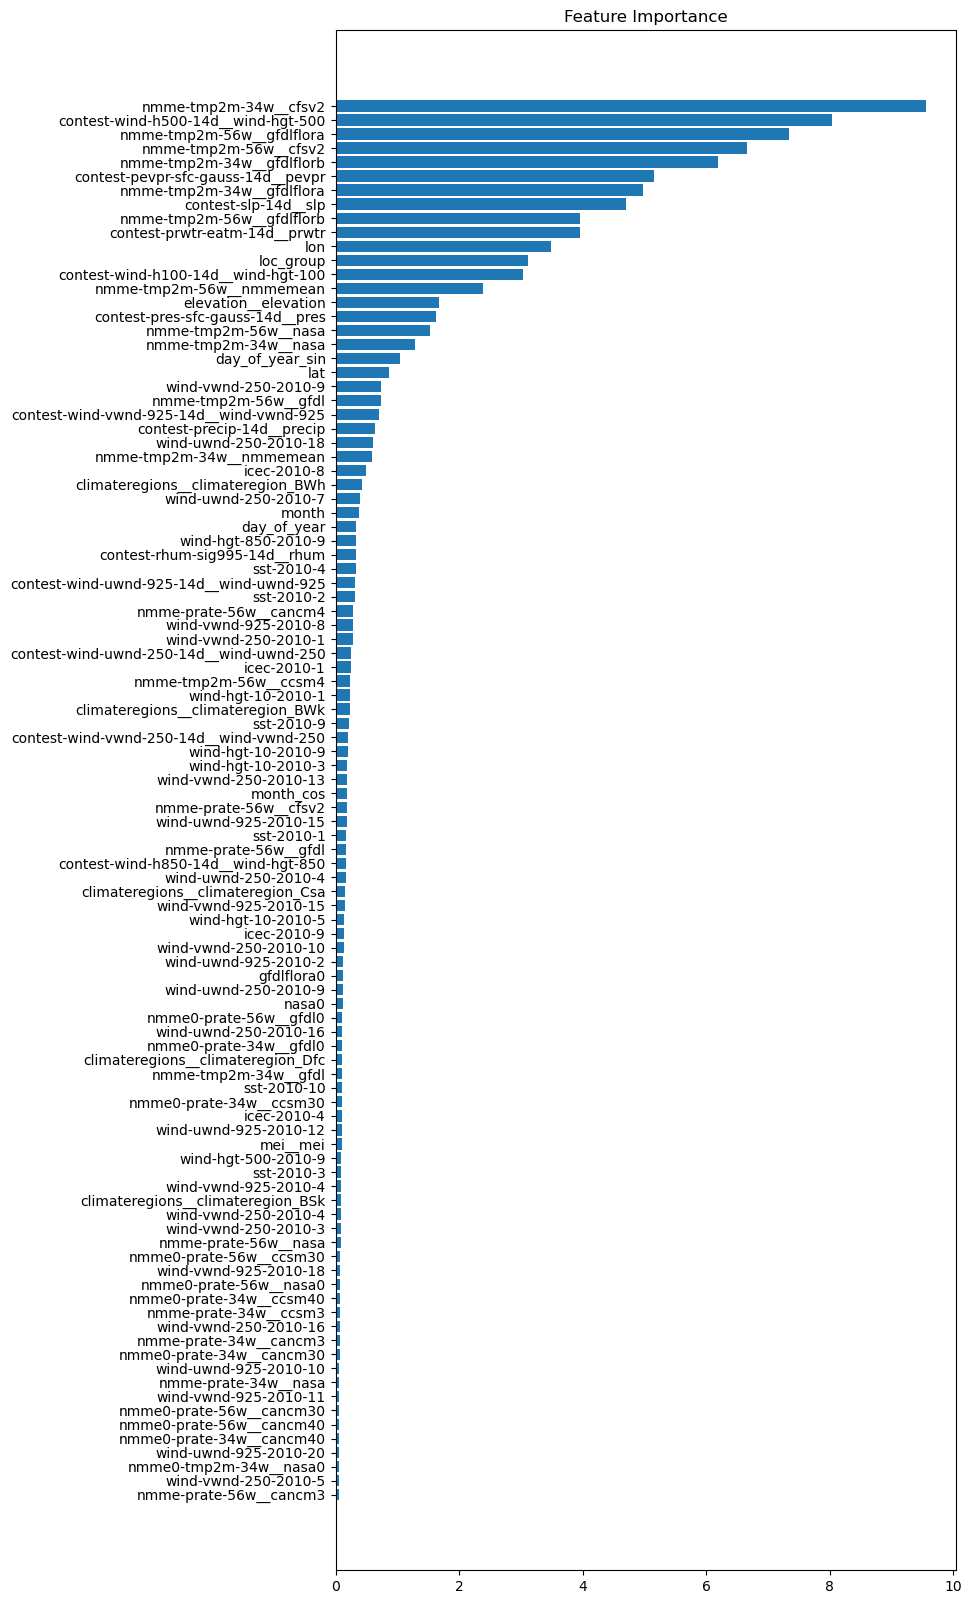

In [50]:
import matplotlib.pyplot as plt
feature_importance = bst.feature_importances_
max_features = 100
sorted_idx = np.argsort(feature_importance)[-max_features:]
fig = plt.figure(figsize=(8, 20))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
plt.title('Feature Importance')

<a id = "xml"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Machine Learning Explainability</b></div>

<div style="text-align: justify;">In this section, we showcase a sample of SHAP explainability evaluation for our model. SHAP (SHapley Additive exPlanations) is a popular approach for providing model interpretability by measuring the contribution of each feature to a prediction. This enables us to identify which features have the greatest impact on our model's outputs, and how they are related to the predicted values. 
To perform the SHAP evaluation, we first generate a set of test data and extract the features we want to evaluate. We then use the SHAP library to compute the SHAP values for each feature, which represent the change in the predicted value as a result of changing the feature value while holding all other features constant. These values are visualized using a SHAP summary plot, which shows the features ranked by their importance and the direction of their impact on the predicted value. Through the SHAP summary plot, we can observe the top contributing features to our model's predictions, and how they are positively or negatively correlated with the output. This enables us to gain insights into the underlying relationships between the features and the target variable, improving our understanding of how our model makes its predictions. Overall, the SHAP explainability evaluation provides a valuable tool for gaining insights into the inner workings of our model and making informed decisions based on its outputs.</div>

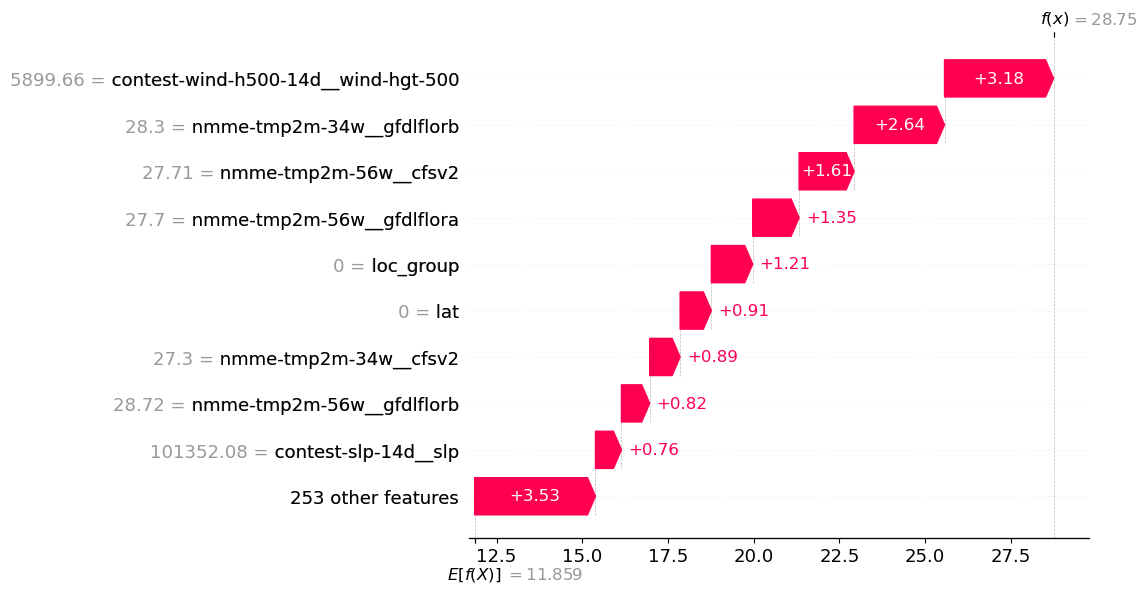

In [ ]:
import shap

explainer = shap.Explainer(bst)
shap_values = explainer(X1)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

<a id = "PL"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Pseudo Labeling and Postprocessing</b></div>

In [59]:
# Pseudo Labelling
train_pseudo = X_test.copy()
ddf = pd.read_csv('y_pred_cat.csv')
# ddf = pd.read_csv('../../data/old.csv')
y_test_pred  = ddf[target] #bst.predict(X_test)
train_pseudo[target] = y_test_pred
train_mod = pd.concat([X_train.copy(), train_pseudo], axis=0).reset_index(drop=True)
features = [c for c in X_test.columns if (c != 'id')]
display(train_mod)

XX = train_mod[features]
yy = train_mod[target]
y_oof_pred = np.zeros(len(yy))

X_testt = X_test[features].values
y_test_pred2 = np.zeros(len(X_testt))

,lat,lon,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,nmme0-tmp2m-34w__gfdl0,nmme0-tmp2m-34w__nasa0,nmme0-tmp2m-34w__nmme0mean,contest-wind-h10-14d__wind-hgt-10,nmme-tmp2m-56w__cancm3,nmme-tmp2m-56w__cancm4,nmme-tmp2m-56w__ccsm3,nmme-tmp2m-56w__ccsm4,nmme-tmp2m-56w__cfsv2,nmme-tmp2m-56w__gfdl,nmme-tmp2m-56w__gfdlflora,nmme-tmp2m-56w__gfdlflorb,nmme-tmp2m-56w__nasa,nmme-tmp2m-56w__nmmemean,contest-rhum-sig995-14d__rhum,nmme-prate-34w__cancm3,nmme-prate-34w__cancm4,nmme-prate-34w__ccsm3,nmme-prate-34w__ccsm4,nmme-prate-34w__cfsv2,nmme-prate-34w__gfdl,nmme-prate-34w__gfdlflora,nmme-prate-34w__gfdlflorb,nmme-prate-34w__nasa,nmme-prate-34w__nmmemean,contest-wind-h100-14d__wind-hgt-100,nmme0-prate-56w__cancm30,nmme0-prate-56w__cancm40,nmme0-prate-56w__ccsm30,nmme0-prate-56w__ccsm40,nmme0-prate-56w__cfsv20,nmme0-prate-56w__gfdlflora0,nmme0-prate-56w__gfdlflorb0,nmme0-prate-56w__gfdl0,nmme0-prate-56w__nasa0,nmme0-prate-56w__nmme0mean,nmme0-prate-34w__cancm30,nmme0-prate-34w__cancm40,nmme0-prate-34w__ccsm30,nmme0-prate-34w__ccsm40,nmme0-prate-34w__cfsv20,nmme0-prate-34w__gfdlflora0,nmme0-prate-34w__gfdlflorb0,nmme0-prate-34w__gfdl0,nmme0-prate-34w__nasa0,nmme0-prate-34w__nmme0mean,contest-slp-14d__slp,contest-wind-vwnd-925-14d__wind-vwnd-925,nmme-prate-56w__cancm3,nmme-prate-56w__cancm4,nmme-prate-56w__ccsm3,nmme-prate-56w__ccsm4,nmme-prate-56w__cfsv2,nmme-prate-56w__gfdl,nmme-prate-56w__gfdlflora,nmme-prate-56w__gfdlflorb,nmme-prate-56w__nasa,nmme-prate-56w__nmmemean,contest-pres-sfc-gauss-14d__pres,contest-wind-uwnd-250-14d__wind-uwnd-250,nmme-tmp2m-34w__cancm3,nmme-tmp2m-34w__cancm4,nmme-tmp2m-34w__ccsm3,nmme-tmp2m-34w__ccsm4,nmme-tmp2m-34w__cfsv2,nmme-tmp2m-34w__gfdl,nmme-tmp2m-34w__gfdlflora,nmme-tmp2m-34w__gfdlflorb,nmme-tmp2m-34w__nasa,nmme-tmp2m-34w__nmmemean,contest-prwtr-eatm-14d__prwtr,contest-wind-vwnd-250-14d__wind-vwnd-250,contest-precip-14d__precip,contest-wind-h850-14d__wind-hgt-850,contest-wind-uwnd-925-14d__wind-uwnd-925,contest-wind-h500-14d__wind-hgt-500,cancm30,cancm40,ccsm30,ccsm40,cfsv20,gfdlflora0,gfdlflorb0,gfdl0,nasa0,nmme0mean,elevation__elevation,wind-vwnd-250-2010-1,wind-vwnd-250-2010-2,wind-vwnd-250-2010-3,wind-vwnd-250-2010-4,wind-vwnd-250-2010-5,wind-vwnd-250-2010-6,wind-vwnd-250-2010-7,wind-vwnd-250-2010-8,wind-vwnd-250-2010-9,wind-vwnd-250-2010-10,wind-vwnd-250-2010-11,wind-vwnd-250-2010-12,wind-vwnd-250-2010-13,wind-vwnd-250-2010-14,wind-vwnd-250-2010-15,wind-vwnd-250-2010-16,wind-vwnd-250-2010-17,wind-vwnd-250-2010-18,wind-vwnd-250-2010-19,wind-vwnd-250-2010-20,wind-uwnd-250-2010-1,wind-uwnd-250-2010-2,wind-uwnd-250-2010-3,wind-uwnd-250-2010-4,wind-uwnd-250-2010-5,wind-uwnd-250-2010-6,wind-uwnd-250-2010-7,wind-uwnd-250-2010-8,wind-uwnd-250-2010-9,wind-uwnd-250-2010-10,wind-uwnd-250-2010-11,wind-uwnd-250-2010-12,wind-uwnd-250-2010-13,wind-uwnd-250-2010-14,wind-uwnd-250-2010-15,wind-uwnd-250-2010-16,wind-uwnd-250-2010-17,wind-uwnd-250-2010-18,wind-uwnd-250-2010-19,wind-uwnd-250-2010-20,mjo1d__phase,mjo1d__amplitude,mei__mei,mei__meirank,mei__nip,wind-hgt-850-2010-1,wind-hgt-850-2010-2,wind-hgt-850-2010-3,wind-hgt-850-2010-4,wind-hgt-850-2010-5,wind-hgt-850-2010-6,wind-hgt-850-2010-7,wind-hgt-850-2010-8,wind-hgt-850-2010-9,wind-hgt-850-2010-10,sst-2010-1,sst-2010-2,sst-2010-3,sst-2010-4,sst-2010-5,sst-2010-6,sst-2010-7,sst-2010-8,sst-2010-9,sst-2010-10,wind-hgt-500-2010-1,wind-hgt-500-2010-2,wind-hgt-500-2010-3,wind-hgt-500-2010-4,wind-hgt-500-2010-5,wind-hgt-500-2010-6,wind-hgt-500-2010-7,wind-hgt-500-2010-8,wind-hgt-500-2010-9,wind-hgt-500-2010-10,icec-2010-1,icec-2010-2,icec-2010-3,icec-2010-4,icec-2010-5,icec-2010-6,icec-2010-7,icec-2010-8,icec-2010-9,icec-2010-10,wind-uwnd-925-2010-1,wind-uwnd-925-2010-2,wind-uwnd-925-2010-3,wind-uwnd-925-2010-4,wind-uwnd-925-2010-5,wind-uwnd-925-2010-6,wind-uwnd-925-2010-7,wind-uwnd-925-2010-8,wind-

In [60]:
yy[np.isnan(yy)] = 0
train_pool = Pool(data=XX,label = yy)

X_train3, X_test3, y_trai3, y_test3 = train_test_split(XX, yy, test_size=0.20, random_state=42)

bst2 = CatBoostRegressor(**opt_params)
bst2.fit(train_pool, eval_set=(X_test3, y_test3), plot=True,silent=True)
print(bst2.get_best_score())


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'learn': {'RMSE': 0.01892959868423017}, 'validation': {'RMSE': 0.019118998861506968}}


In [61]:
y_pred_cat = bst2.predict(X_test)
submit_cat = submit.copy()
submit_cat[target] = y_pred_cat
submit_cat.to_csv('y_pred_cat_self_pseudo.csv', index = False)

<a id = "EL"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Ensemble Learning</b></div>

In [23]:
import lightgbm as lgb

# set up parameters for LightGBM
params = {'boosting_type': 'gbdt',
          'objective': 'regression',
          'metric': 'rmse',
          'max_depth': 4,
          'num_leaves': 31,
          'learning_rate': 0.05,
          'feature_fraction': 0.9,
          'bagging_fraction': 0.8,
          'bagging_freq': 5,
          'early_stopping_round': 50,
          'n_estimators': 15000}

reg_lgb = lgb.LGBMRegressor(**params)

reg_lgb.fit(X_train3, y_trai3, eval_set=(X_test3, y_test3),verbose=100)



y_pred_lgb = reg_lgb.predict(X_test)

ensemble_preds = y_pred_lgb*0.40+y_pred_cat*0.60

'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[100]	valid_0's rmse: 0.270878
[200]	valid_0's rmse: 0.216232
[300]	valid_0's rmse: 0.188835
[400]	valid_0's rmse: 0.168992
[500]	valid_0's rmse: 0.152877
[600]	valid_0's rmse: 0.142579
[700]	valid_0's rmse: 0.133708
[800]	valid_0's rmse: 0.126779
[900]	valid_0's rmse: 0.12092
[1000]	valid_0's rmse: 0.116381
[1100]	valid_0's rmse: 0.111989
[1200]	valid_0's rmse: 0.108341
[1300]	valid_0's rmse: 0.105403
[1400]	valid_0's rmse: 0.102189
[1500]	valid_0's rmse: 0.099675
[1600]	valid_0's rmse: 0.097337
[1700]	valid_0's rmse: 0.0953608
[1800]	valid_0's rmse: 0.0932779
[1900]	valid_0's rmse: 0.0917453
[2000]	valid_0's rmse: 0.0903807
[2100]	valid_0's 

In [24]:


submit_lgb = submit.copy()
submit_lgb[target] = y_pred_lgb
submit_lgb.to_csv('y_pred_lgb.csv', index = False)

<a id="submit"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>Submission</b></div>

In [26]:
submit[target] = ensemble_preds
submit.to_csv('submission_combined.csv', index = False)

<a id = "list"></a>
<div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#254E58;overflow:hidden"><b>List of Kaggle Notebooks Used as a Reference</b></div>

<div style="background-color:aliceblue; padding:30px; font-size:15px;color:#034914">

* [[WiDS 2023] Simple basline - RMSE 1.14](https://www.kaggle.com/code/ducanger/wids-2023-simple-basline-rmse-1-14) by [DAT DO](https://www.kaggle.com/ducanger) used as base especially for preprocessing.
* [🔥 EDA & ML on Game Play 🎮 (ongoing)](https://www.kaggle.com/code/nguyenthicamlai/eda-ml-on-game-play-ongoing) by [Nguyen Thi Cam Lai](https://www.kaggle.com/nguyenthicamlai) used for HTML-based headers
* [[WiDS 2021] Tips & Tricks (CatBoost Version)](https://www.kaggle.com/code/kooaslansefat/tips-tricks-catboost-version) used for hyperparameter tunning for CatBoost and adversarial validation
* [WiDS2023_Data_Buddies](https://www.kaggle.com/code/nicholasdominic/wids2023-data-buddies) by [Nicholas Dominic](https://www.kaggle.com/nicholasdominic) for Ensemble Learning

<center> <a href="#TOC" role="button" aria-pressed="true" >⬆️Back to Table of Contents ⬆️</a>

<div style="border-radius:10px;border:#034914 solid;padding: 15px;background-color:aliceblue;font-size:90%;text-align:left">

<h4><b>Authors :</b> Mojgan Hashemian and Koorosh Aslansefat </h4>  
    
<center> <strong> If you liked this Notebook, please do upvote. </strong>
    
<center> <strong> If you have any questions, feel free to contact us! </strong>

<center> <img src="https://gregcfuzion.files.wordpress.com/2022/01/kind-regards-2.png" style='width: 600px; height: 300px;'>